# **Installs & Imports**

In [ ]:
!pip install pymysql
!pip install meteostat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 914.8 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import seaborn as sns

import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

from meteostat import Point, Daily

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

from pandas import DataFrame
from pandas import concat

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Functions

In [ ]:
# Función para imprimir por pantalla características importantes de los datos
def inspect_data(df):
    print('Dimensiones del conjunto de datos')
    print('\n')
    print(df.shape)
    print('\n')
    print('Datos vacíos: ')
    print(df.isnull().sum())
    print('\n')
    print('Tipo de datos: ')
    print(df.dtypes)

In [ ]:
def series_to_supervised(data, n_in_daily=1, n_in_weekly=1, n_out=1, dropnan=True):
    """
    Adapta un problema de series temporales a aprendizaje supervisado.
    Arguments:
      data: secuencia de observaciones como numpy array
      n_in_daily: ancho de la ventana (nº de observaciones) como input (X).
      n_out: ancho de la ventana (nº de observaciones) como output (y).
      dropnan: booleano para indicar si elimino los NaN o no
    Returns:
      Pandas DataFrame de la series para aprendizaje supervisado.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # input sequence sales for days (t-n, ... t-1)
    for i in range(n_in_daily, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d day)' % (j+1, i)) for j in range(n_vars)]
    # input sequence sales for weeks (t-n, ... t-1)
    for i in range(n_in_weekly, 0, -1):
      cols.append(df.shift(i*7))
      names += [('var%d(t-%d week)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Se junta todo
    agg = concat(cols, axis=1)
    agg.columns = names
    # Eliminación de NaN
    if dropnan:
      agg.dropna(inplace=True)

    return agg

In [ ]:
# Función para codificar las variables categóricas a numéricas. Feature: xxxr
def OHE_xxx(data):
  # One hot encoder

  X = np.array(data[["xxx"]])  # Data a codificar

  # Defino el modelo
  enc = OneHotEncoder()
  # Fit & transform
  enc.fit(X)
  Xohe = enc.transform(X).toarray()
  # Actualizo mi dataset con los datos procesados
  dataxxx = pd.DataFrame(Xohe, columns=["aaa", "bbb"]) # posibles valores de xxx
  data = pd.concat([data.drop("xxx", axis=1),dataxxx], axis=1)

  return data

In [ ]:
def tsscale(df):
  dfScaled = df.copy()
  colstoscaled = df.columns[1:]
  newcols = []
  for i in colstoscaled:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.array(df[i]).reshape(-1,1)) #Reshape: Lo convierte a columna
    j = i+"_scaled"
    newcols.append(j)
    dfScaled[j] = scaler.transform(np.array(df[i]).reshape(-1,1))
    if i == "var1(t)":  # Nos quedamos con el scaler de la variable dependiente para desescalar las predicciones y analizarlo
      scalerToUnscale = scaler
  return dfScaled, scalerToUnscale

# 1. Query to database

In [ ]:
class DatabaseConnection:

    def __init__(self, password,
                 dialect = "mysql",
                 driver = "pymysql",
                 username = "********",
                 host = "**********.cxlpff3hacbu.eu-west-3.rds.amazonaws.com",
                 port = "3306",
                 database = "sandbox"):

        self.__password = password
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    def query_to_df(self, query):
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df




In [ ]:
    database = DatabaseConnection("**********")

In [ ]:

query_daily_and_top = """
SELECT familia,
articulo,
fechaVenta AS fecha_venta,
festivo,
precio,
cantidad,
importe,
orden_articulo_familia

FROM DSIIIMSA_ventas_diarias_estudio
"""

# Return query as panda dataframe
ventas = database.query_to_df(query_daily_and_top)

# Fix formats:'fecha_venta'as datetime, 'articulo' as int
ventas = (
           ventas.assign(fecha_venta = pd.to_datetime(ventas["fecha_venta"]))
                 .astype({"articulo": int})
        )

ventas

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3960,2021-05-18,None,2.318000,216.000000,500.688008,1
1,BOLLERIA,6286,2021-08-29,None,3.136000,99.000000,310.464005,4
2,BOLLERIA,3880,2021-09-21,None,3.000000,102.000000,306.000000,3
3,BOLLERIA,5803,2021-10-21,None,3.000000,42.000000,126.000000,5
4,BOLLERIA,3880,2021-12-07,None,3.000000,141.000000,423.000000,3
...,...,...,...,...,...,...,...,...
10317,PASTELERIA,6451,2023-02-07,None,43.500000,3.000000,130.500000,4
10318,PASTELERIA,6523,2023-04-01,None,40.772999,18.000000,733.914001,3
10319,PASTELERIA,6451,2023-04-02,Domingo de Ramos,43.500000,18.000000,783.000000,4
10320,PASTELERIA,5404,2023-04-15,None,43.500000,52.199999,2270.700058,1


In [ ]:
ventas.describe()

,articulo,fecha_venta,precio,cantidad,importe,orden_articulo_familia
count,10322.000000,10322,10322.000000,10322.000000,10322.000000,10322.000000
mean,3945.385197,2022-04-29 14:56:20.275140608,15.398333,138.341943,462.696012,2.961538
min,417.000000,2021-05-01 00:00:00,0.865000,1.200000,9.000000,1.000000
25%,1043.000000,2021-10-28 00:00:00,2.591000,15.000000,288.000000,2.000000
50%,5403.000000,2022-04-29 00:00:00,3.545000,84.000000,405.651001,3.000000
75%,6286.000000,2022-10-29 00:00:00,34.091000,219.000000,569.453926,4.000000
max,6549.000000,2023-04-30 00:00:00,43.500000,1110.000000,3271.929962,5.000000
std,2404.409766,NaN,16.987621,148.997454,273.909048,1.395584


# 2. Query to [meteostat API](https://dev.meteostat.net/python/daily.html)

Data dictionary:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [ ]:
class DailyWeatherData:

    # Geographical coordinates of Panadería Salvador Echeverría
    ECHEVERRIA_SHOP = Point(36.721477644071705, -4.363132134392174)

    # Select columns
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Time range to query API
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # Daily query
    def get_weather_data(self):
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

In [ ]:
start = ventas["fecha_venta"].min()
end = ventas["fecha_venta"].max()

weather_query = DailyWeatherData(start, end)

# Get meteorological dataframe
weather = weather_query.get_weather_data()

weather

,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,233.0,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,272.0,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,206.0,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,132.0,13.8,1016.5
...,...,...,...,...,...,...,...,...
725,2023-04-26,20.3,15.5,26.0,0.0,93.0,10.7,1014.0
726,2023-04-27,19.1,15.0,24.5,0.0,122.0,9.9,1015.1
727,2023-04-28,20.8,16.6,26.7,0.0,144.0,14.3,1015.2
728,2023-04-29,25.6,18.7,34.3,0.0,289.0,16.9,1015.4


# 3. Complete data

In [ ]:
# Join on 'fecha_venta'
df = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenar el dataframe
df.sort_values(["articulo", "fecha_venta"], inplace = True)

df.head(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
8743,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,282.0,14.2,1014.0
2005,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,16.3,10.8,23.2,0.0,233.0,15.7,1015.9
9594,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,15.3,12.7,20.1,6.5,272.0,9.7,1017.7
2612,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,16.5,12.0,20.9,0.0,206.0,12.1,1018.0
8105,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,16.7,12.3,21.7,0.0,132.0,13.8,1016.5


In [ ]:
# 1 <-- Cardinality
# 2 <-- Nulls_Pct

(df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    .assign(Max = df.dropna().apply(max))
    .assign(Min = df.dropna().apply(min))
    .sort_values(["Tipo"])
)

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
articulo,int64,15,0.145321,0.000000,6549,417
fecha_venta,datetime64[ns],730,7.072273,0.000000,2023-04-09 00:00:00,2021-05-02 00:00:00
orden_articulo_familia,int64,5,0.048440,0.000000,5,1
precio,float64,45,0.435962,0.000000,43.5,0.865
cantidad,float64,1389,13.456694,0.000000,966.0,3.0
importe,float64,6171,59.784925,0.000000,2377.851974,85.080002
tavg_w,float64,200,1.937609,0.000000,31.1,11.1
tmin_w,float64,212,2.053866,0.000000,26.3,5.2
tmax_w,float64,220,2.131370,0.000000,39.2,15.0
prcp_w,float64,58,0.561907,0.000000,24.1,0.0


In [ ]:
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)
df

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w,es_festivo
8743,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,282.0,14.2,1014.0,0
2005,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,16.3,10.8,23.2,0.0,233.0,15.7,1015.9,1
9594,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,15.3,12.7,20.1,6.5,272.0,9.7,1017.7,1
2612,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,16.5,12.0,20.9,0.0,206.0,12.1,1018.0,0
8105,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,16.7,12.3,21.7,0.0,132.0,13.8,1016.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8803,PASTELERIA,6549,2023-04-24,None,32.591,9.0,293.319008,5,18.4,13.7,25.5,0.0,140.0,11.1,1015.5,0
6092,PASTELERIA,6549,2023-04-25,None,32.591,3.0,97.773003,5,19.4,14.0,28.3,0.0,353.0,11.8,1015.5,0
3487,PASTELERIA,6549,2023-04-28,None,32.591,21.0,684.411018,5,20.8,16.6,26.7,0.0,144.0,14.3,1015.2,0
7939,PASTELERIA,6549,2023-04-29,None,32.591,6.0,195.546005,5,25.6,18.7,34.3,0.0,289.0,16.9,1015.4,0


In [ ]:
  # Coding temperature levels
  #   'Temperatura muy baja' -  1
  #   'Temperatura baja' -      2
  #   'Temperatura normal' -    3
  #   'Temperatura alta' -      4
  #   'Temperatura muy alta' -  5

labels_tavg = [1, 2, 3, 4, 5]

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)
df

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wdir_w,wspd_w,pres_w,es_festivo,quintiles_tavg_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear
8743,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,...,282.0,14.2,1014.0,0,2,17,5,5,1,121
2005,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,16.3,10.8,...,233.0,15.7,1015.9,1,2,17,5,6,2,122
9594,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,15.3,12.7,...,272.0,9.7,1017.7,1,2,18,5,0,3,123
2612,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,16.5,12.0,...,206.0,12.1,1018.0,0,2,18,5,1,4,124
8105,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,16.7,12.3,...,132.0,13.8,1016.5,0,2,18,5,2,5,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8803,PASTELERIA,6549,2023-04-24,None,32.591,9.0,293.319008,5,18.4,13.7,...,140.0,11.1,1015.5,0,3,17,4,0,24,114
6092,PASTELERIA,6549,2023-04-25,None,32.591,3.0,97.773003,5,19.4,14.0,...,353.0,11.8,1015.5,0,3,17,4,1,25,115
3487,PASTELERIA,6549,2023-04-28,None,32.591,21.0,684.411018,5,20.8,16.6,...,144.0,14.3,1015.2,0,3,17,4,4,28,118
7939,PASTELERIA,6549,2023-04-29,None,32.591,6.0,195.546005,5,25.6,18.7,...,289.0,16.9,1015.4,0,5,17,4,5,29,119


# EDA

##  Initial inspection

In [ ]:
df.describe(include='all')

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wdir_w,wspd_w,pres_w,es_festivo,quintiles_tavg_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear
count,10322,10322.000000,10322,809,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,10322.000000,...,10292.000000,10292.000000,10292.000000,10322.000000,10322.0,10322.0,10322.000000,10322.000000,10322.000000,10322.000000
unique,3,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,<NA>,NaN,NaN,NaN,NaN
top,PANADERIA,NaN,NaN,Feria de Málaga,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,<NA>,NaN,NaN,NaN,NaN
freq,3650,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2155.0,<NA>,NaN,NaN,NaN,NaN
mean,NaN,3945.385197,2022-04-29 14:56:20.275140608,NaN,15.398333,138.341943,462.696012,2.961538,19.373164,15.195786,...,216.609114,14.345890,1018.054081,0.078376,NaN,26.491862,6.532746,3.066072,15.719628,183.202189
min,NaN,417.000000,2021-05-01 00:00:00,NaN,0.865000,1.200000,9.000000,1.000000,7.300000,1.100000,...,10.000000,6.000000,1004.400000,0.000000,NaN,1.0,1.000000,0.000000,1.000000,1.000000
25%,NaN,1043.000000,2021-10-28 00:00:00,NaN,2.591000,15.000000,288.000000,2.000000,14.500000,10.800000,...,144.000000,10.900000,1014.500000,0.000000,NaN,14.0,4.000000,1.000000,8.000000,92.000000
50%,NaN,5403.000000,2022-04-29 00:00:00,NaN,3.545000,84.000000,405.651001,3.000000,19.300000,14.600000,...,244.000000,12.500000,1017.300000,0.000000,NaN,26.0,7.000000,3.000000,16.000000,183.000000
75%,NaN,6286.000000,2022-10-29 00:00:00,NaN,34.091000,219.000000,569.453926,4.000000,23.900000,20.100000,...,284.000000,16.900000,1021.000000,0.000000,NaN,39.0,10.000000,5.000000,23.000000,274.000000
max,NaN,6549.000000,2023-04-30 00:00:00,NaN,43.500000,1110.000000,3271.929962,5.000000,33.500000,27.500000,...,356.000000,46.500000,1032.800000,1.000000,NaN,52.0,12.000000,6.000000,31.000000,365.000000


In [ ]:
df[["familia", "articulo"]].drop_duplicates().sort_values("familia").reset_index(drop=True)


,familia,articulo
0,BOLLERIA,3880
1,BOLLERIA,3960
2,BOLLERIA,5803
3,BOLLERIA,6286
4,BOLLERIA,6425
5,PANADERIA,417
6,PANADERIA,900
7,PANADERIA,968
8,PANADERIA,1043
9,PANADERIA,1084


In [ ]:
df_art = df.groupby('articulo')
df_sum = df_art['cantidad'].sum().sort_values(ascending=False)
df_sum
#df_sum.sort_values(ascending=False)

articulo
900     324822.000000
1084    253971.198002
968     191351.690998
3960    178497.000000
1043    135685.344000
3880    109908.000000
6286     72815.928000
5803     59990.790000
417      51384.000000
6425     11951.850011
5404      9901.824011
5403      8960.433012
6523      6914.400000
6451      6258.450001
6549      5552.628000
Name: cantidad, dtype: float64

🕵 The best selling item in **quantity** -> **articulo 900**

In [ ]:
df_art = df.groupby('articulo')
df_sum = df_art['importe'].sum().sort_values(ascending=False)
df_sum
#df_sum.sort_values(ascending=False)

articulo
3960    468386.265908
968     454378.823674
5404    412683.417587
6425    396761.838659
1043    391108.831879
3880    348990.783512
5403    340744.089073
900     309700.320184
6286    269926.185301
6523    263494.083900
6451    261746.688332
1084    260246.016170
417     229203.402578
5803    195727.920692
6549    172849.567284
Name: importe, dtype: float64

🕵 The best selling item in **price** -> **articulo 3960**

<Axes: >

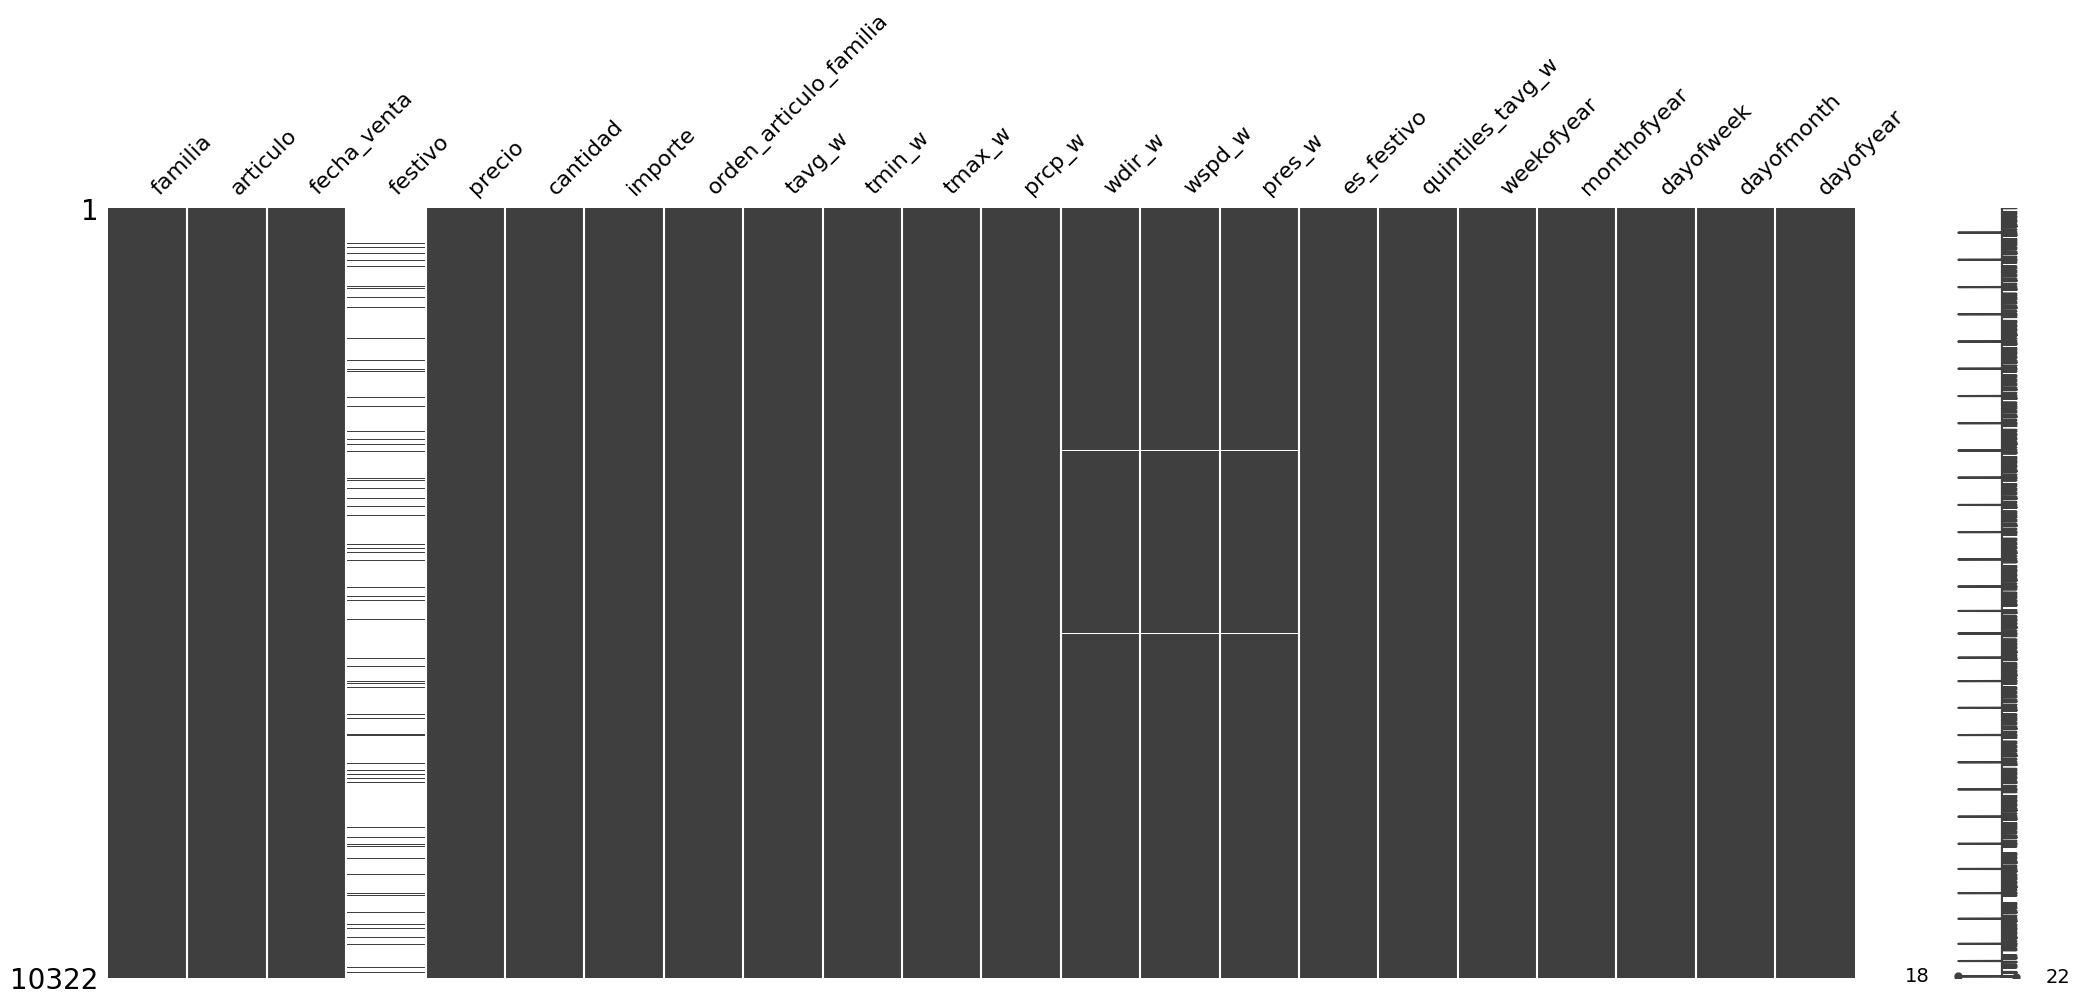

In [ ]:
# 2<--  Nulll values

msno.matrix(df)

In [ ]:
# 3 <-- max and min dates

min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()
num_dias = (max_date - min_date).days +1

print ('min date:', min_date)
print ('max date:', max_date)
print ('num. days: ', num_dias)


min date: 2021-05-01 00:00:00
max date: 2023-04-30 00:00:00
num. days:  730


In [ ]:
# 4 <-- duplicated?

df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]


,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wdir_w,wspd_w,pres_w,es_festivo,quintiles_tavg_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear


In [ ]:
# 5 <-- Missing dates?

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PASTELERIA -> Articulo 6451 -> Fechas faltantes 73
PASTELERIA -> Articulo 6549 -> Fechas faltantes 304
PASTELERIA -> Articulo 6523 -> Fechas faltantes 48
PASTELERIA -> Articulo 5403 -> Fechas faltantes 103
PASTELERIA -> Articulo 5404 -> Fechas faltantes 94


In [ ]:
# 6 <-- Outliers?

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["cantidad"]))

BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 5803 -> Outliers 52
BOLLERIA -> Articulo 3880 -> Outliers 36
BOLLERIA -> Articulo 6286 -> Outliers 57
BOLLERIA -> Articulo 6425 -> Outliers 25
PANADERIA -> Articulo 1084 -> Outliers 6
PANADERIA -> Articulo 417 -> Outliers 19
PANADERIA -> Articulo 900 -> Outliers 30
PANADERIA -> Articulo 968 -> Outliers 27
PANADERIA -> Articulo 1043 -> Outliers 38
PASTELERIA -> Articulo 6451 -> Outliers 22
PASTELERIA -> Articulo 6549 -> Outliers 3
PASTELERIA -> Articulo 6523 -> Outliers 35
PASTELERIA -> Articulo 5403 -> Outliers 38
PASTELERIA -> Articulo 5404 -> Outliers 25


In [ ]:
# Temporal evolution by 'familia' of the variable 'cantidad'

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [ ]:
# Temporal evolution by 'articulo' of the variable 'cantidad'

group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="articulo")
fig.show()

In [ ]:
# Check if the process is stationary

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

ADF Statistic:  -1.479741416908732
p-value:  0.5435081108638741
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Non-stationary 


In [ ]:
# Check if the process is stationary by taking the first difference
# We can take the first difference to see if our series becomes stationary.
# This eliminates trends and stabilizes the variance of the series, allowing it to be modeled.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

ADF Statistic:  -12.362896381034222
p-value:  5.49566965254961e-23
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Stationary 


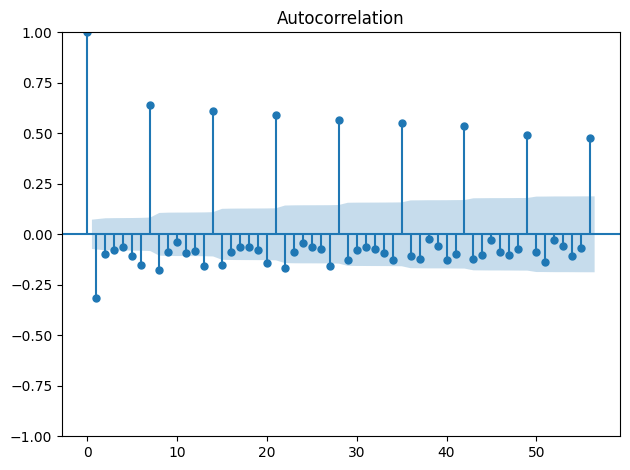

In [ ]:
# Autocorrelation analysis
# There seems to be weekly seasonality

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

In [ ]:
# CORRELATION at the FAMILY level by week, month and year

df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.dayofweek #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

# A nivel familia
graph_by_freq("dayofweek")
graph_by_freq("dayofmonth")
graph_by_freq("dayofyear")


In [ ]:
# CORRELATION at ARTICLE level by week, month and year
graph_by_freq("dayofweek", "articulo")
graph_by_freq("dayofmonth", "articulo")
graph_by_freq("dayofyear", "articulo")


**FIRST CONCLUSIONS** 🕵

It seems that 'cantidad' values ​​could have a relationship with their value from last week, since there seems to be a weekly purchasing pattern that repeats itself over time.

## Establish the scope of the project

**OBJECTIVE** --> Set the prediction of the QUANTITY OF SALES for the first weeks of MAY23.

- OPTION 1: TARGET to the 15 articles in the TOP 5 families (in price)
- OPTION 2: TARGET to the TOP article (in price) --> 3960

THE PROJECT STANDS FOR OPTION 2

**--> Set the prediction of the sales amount of article 3690 for the first weeks of MAY23 based in sales data from MAY21 to APR23 <--**

In [ ]:
family = "BOLLERIA"
item = 3960

itemdata = df.loc[((df["familia"]==family)&(df["articulo"]==item))].reset_index(drop=True).copy()
itemdata["fecha_venta"] = pd.to_datetime(itemdata["fecha_venta"])
itemdata.sort_values("fecha_venta", ascending=True, inplace=True)
itemdata

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,...,wdir_w,wspd_w,pres_w,es_festivo,quintiles_tavg_w,weekofyear,monthofyear,dayofweek,dayofmonth,dayofyear
0,BOLLERIA,3960,2021-05-01,None,2.318,402.0,931.835995,1,17.2,11.9,...,282.0,14.2,1014.0,0,2,17,5,5,1,121
1,BOLLERIA,3960,2021-05-02,Día de la Madre,2.318,369.0,855.341996,1,16.3,10.8,...,233.0,15.7,1015.9,1,2,17,5,6,2,122
2,BOLLERIA,3960,2021-05-03,Día de la Cruz,2.318,228.0,528.503994,1,15.3,12.7,...,272.0,9.7,1017.7,1,2,18,5,0,3,123
3,BOLLERIA,3960,2021-05-04,None,2.318,237.0,549.365999,1,16.5,12.0,...,206.0,12.1,1018.0,0,2,18,5,1,4,124
4,BOLLERIA,3960,2021-05-05,None,2.318,288.0,667.584000,1,16.7,12.3,...,132.0,13.8,1016.5,0,2,18,5,2,5,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,BOLLERIA,3960,2023-04-26,None,3.273,162.0,530.226013,1,20.3,15.5,...,93.0,10.7,1014.0,0,3,17,4,2,26,116
726,BOLLERIA,3960,2023-04-27,None,3.273,216.0,706.968018,1,19.1,15.0,...,122.0,9.9,1015.1,0,3,17,4,3,27,117
727,BOLLERIA,3960,2023-04-28,None,3.273,183.0,598.959015,1,20.8,16.6,...,144.0,14.3,1015.2,0,3,17,4,4,28,118
728,BOLLERIA,3960,2023-04-29,None,3.273,249.0,814.977020,1,25.6,18.7,...,289.0,16.9,1015.4,0,5,17,4,5,29,119


In [ ]:
inspect_data(itemdata)

Dimensiones del conjunto de datos


(730, 22)


Datos vacíos: 
familia                     0
articulo                    0
fecha_venta                 0
festivo                   673
precio                      0
cantidad                    0
importe                     0
orden_articulo_familia      0
tavg_w                      0
tmin_w                      0
tmax_w                      0
prcp_w                      0
wdir_w                      2
wspd_w                      2
pres_w                      2
es_festivo                  0
quintiles_tavg_w            0
weekofyear                  0
monthofyear                 0
dayofweek                   0
dayofmonth                  0
dayofyear                   0
dtype: int64


Tipo de datos: 
familia                           object
articulo                           int64
fecha_venta               datetime64[ns]
festivo                           object
precio                           float64
cantidad                         float64


In [ ]:
itemdata = itemdata[['fecha_venta', 'festivo', 'cantidad','es_festivo', 'prcp_w', 'quintiles_tavg_w']]
itemdata

,fecha_venta,festivo,cantidad,es_festivo,prcp_w,quintiles_tavg_w
0,2021-05-01,None,402.0,0,0.0,2
1,2021-05-02,Día de la Madre,369.0,1,0.0,2
2,2021-05-03,Día de la Cruz,228.0,1,6.5,2
3,2021-05-04,None,237.0,0,0.0,2
4,2021-05-05,None,288.0,0,0.0,2
...,...,...,...,...,...,...
725,2023-04-26,None,162.0,0,0.0,3
726,2023-04-27,None,216.0,0,0.0,3
727,2023-04-28,None,183.0,0,0.0,3
728,2023-04-29,None,249.0,0,0.0,5


In [ ]:
itemdataAnual =itemdata.copy()
itemdataAnual["year"] = itemdata["fecha_venta"].dt.year


In [ ]:
# studing weekly patterns

group = itemdataAnual.groupby(["year", pd.Grouper(key="fecha_venta", freq="1W")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="year")
fig.show()

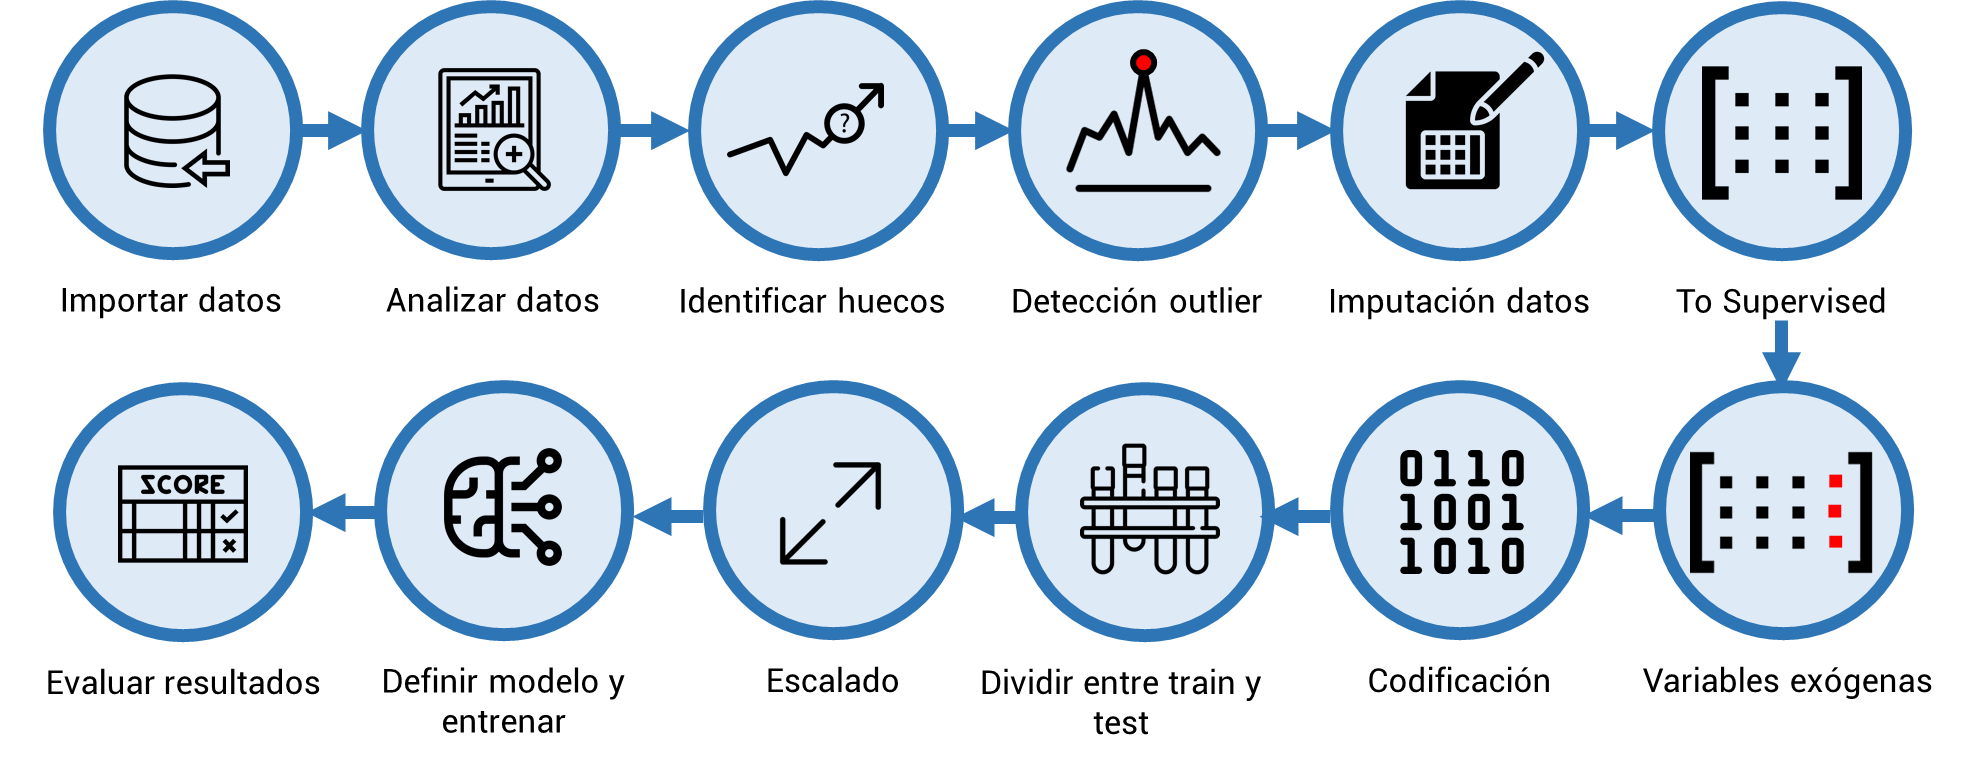

## Data cleaning

In [ ]:
list(itemdata["festivo"].unique())


[None,
 'Día de la Madre',
 'Día de la Cruz',
 'Día de San Juan',
 'Día de la Virgen del Carmen',
 'Día de la Victoria',
 'Fiesta de la Virgen de la Victoria',
 'Día de la Hispanidad (Fiesta Nacional de España)',
 'Noche de Halloween',
 'Día de Todos los Santos',
 'Día de la Constitución',
 'Nochebuena',
 'Navidad',
 'Nochevieja',
 'Año Nuevo',
 'Día de Reyes',
 'Día de San Valentín',
 'Día del Padre',
 'Domingo de Ramos',
 'Lunes Santo',
 'Martes Santo',
 'Miércoles Santo',
 'Jueves Santo',
 'Viernes Santo',
 'Sábado Santo',
 'Domingo de Resurrección',
 'Feria de Málaga']

In [ ]:
itemdata_aux = itemdata.dropna(subset=["festivo"]).sort_values("fecha_venta").reset_index(drop=True)
itemdata_aux


,fecha_venta,festivo,cantidad,es_festivo,prcp_w,quintiles_tavg_w
0,2021-05-02,Día de la Madre,369.0,1,0.0,2
1,2021-05-03,Día de la Cruz,228.0,1,6.5,2
2,2021-06-24,Día de San Juan,186.0,1,0.0,4
3,2021-07-16,Día de la Virgen del Carmen,315.0,1,0.0,4
4,2021-08-19,Día de la Victoria,240.0,1,0.0,5
5,2021-09-08,Fiesta de la Virgen de la Victoria,126.0,1,0.0,5
6,2021-10-12,Día de la Hispanidad (Fiesta Nacional de España),375.0,1,0.0,3
7,2021-10-31,Noche de Halloween,411.0,1,0.0,4
8,2021-11-01,Día de Todos los Santos,351.0,1,0.0,4
9,2021-12-06,Día de la Constitución,321.0,1,0.0,2


🕵 We notice that the some holidays are missing:

    - Día de Andalucía (28/02)
    - Día de la Inmaculada (08/12)
    - Feria de Málaga 2021 was cancelled, there are not values, it's ok.


In [ ]:
# Add missing holidays

itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2022,2,28), "festivo"] = "Día de Andalucía"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2023,2,28), "festivo"] = "Día de Andalucía"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2021,12,8), "festivo"] = "Día de la Inmaculada"
itemdata.loc[itemdata["fecha_venta"]==datetime.datetime(2022,12,8), "festivo"] = "Día de la Inmaculada"

In [ ]:
itemdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_venta       730 non-null    datetime64[ns]
 1   festivo           61 non-null     object        
 2   cantidad          730 non-null    float64       
 3   es_festivo        730 non-null    int64         
 4   prcp_w            730 non-null    float64       
 5   quintiles_tavg_w  730 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 29.6+ KB


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["es_festivo"], name="Día festivo"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Festivo", secondary_y=True)

fig.show()

In [ ]:
itemdata_fest = itemdata.dropna(subset=["festivo"]).sort_values("fecha_venta").reset_index(drop=True)
itemdata_fest['year']= itemdata_fest['fecha_venta'].dt.year
itemdata_fest.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_venta       61 non-null     datetime64[ns]
 1   festivo           61 non-null     object        
 2   cantidad          61 non-null     float64       
 3   es_festivo        61 non-null     int64         
 4   prcp_w            61 non-null     float64       
 5   quintiles_tavg_w  61 non-null     category      
 6   year              61 non-null     int32         
dtypes: category(1), datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 3.0+ KB


In [ ]:
itemdata_fest['year'] = itemdata_fest['year'].astype(str)

In [ ]:
# Comparing holidays by year

group = itemdata_fest.groupby(["year", "festivo"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='festivo', y='cantidad', color="year",barmode='group')
fig.show()

In [ ]:
# mark relevant holidays

fest_TOP =  ['Día de Andalucía','Día de la Madre','Día de la Hispanidad (Fiesta Nacional de España)', 'Año Nuevo']
itemdata["tipo_festivo"] = np.where(itemdata["festivo"].isin(fest_TOP),1, 0)


In [ ]:
# For better knowing if it is or it is not rainnig

itemdata["lluvia"] = np.where(itemdata["prcp_w"]>0,1,0)
itemdata.drop('prcp_w', axis=1, inplace=True)

In [ ]:
inspect_data(itemdata)

Dimensiones del conjunto de datos


(730, 7)


Datos vacíos: 
fecha_venta           0
festivo             669
cantidad              0
es_festivo            0
quintiles_tavg_w      0
tipo_festivo          0
lluvia                0
dtype: int64


Tipo de datos: 
fecha_venta         datetime64[ns]
festivo                     object
cantidad                   float64
es_festivo                   int64
quintiles_tavg_w          category
tipo_festivo                 int64
lluvia                       int64
dtype: object


In [ ]:
# Rain patterns

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["lluvia"], name="Lluvia S/N"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Lluvia S/N", secondary_y=True)

fig.show()

In [ ]:
# Buscamos patrones por temperaturas máximas.

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["cantidad"], name="Cantidad vendida"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=itemdata["fecha_venta"], y=itemdata["quintiles_tavg_w"], name="Temperatura"),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Fecha")

# Set y-axes titles
fig.update_yaxes(title_text="Ventas", secondary_y=False)
fig.update_yaxes(title_text="Temperatura", secondary_y=True)

fig.show()

In [ ]:
itemdata_corr = itemdata[['cantidad','es_festivo', 'tipo_festivo','quintiles_tavg_w', 'lluvia']]
corr_matrix = itemdata_corr.corr()

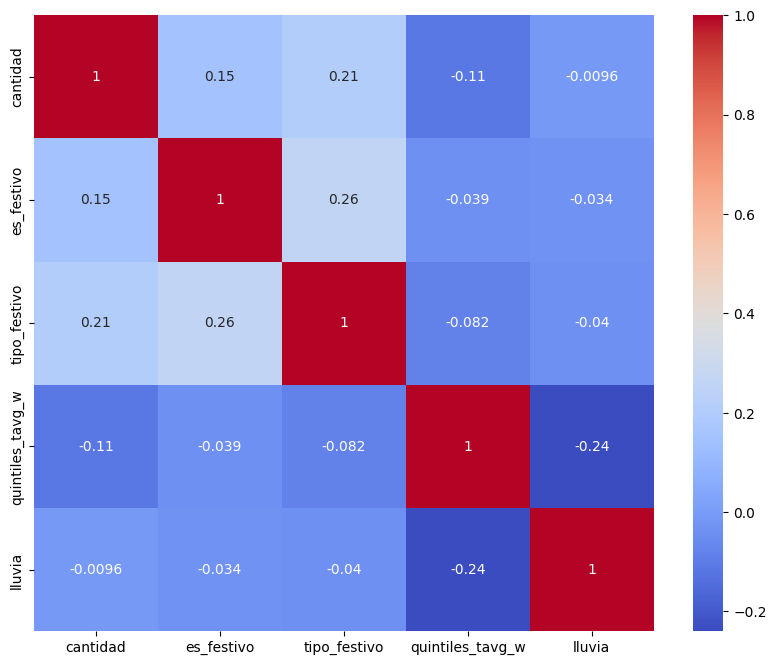

In [ ]:
plt.figure(figsize=(10, 8))  # Tamaño de la figura
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.show()

## 🕵 Some conclusions

- It does not seem that there will be significant effects due to maximum temperatures or price increases.
- Yes, there seems to be an impact on certain holidays (not all).
- There does seem to be an inverse acceleration (peaks to valleys and valleys to peaks) with the minimum temperature.
- There does not seem to be an annual seasonality, but there is a weekly one.
- It does seem that there is a differentiation between weekdays and weekends.


# PREPROCESSING

In [ ]:
itemSales = itemdata[['fecha_venta', 'cantidad', 'tipo_festivo']]
inspect_data(itemSales)

Dimensiones del conjunto de datos


(730, 3)


Datos vacíos: 
fecha_venta     0
cantidad        0
tipo_festivo    0
dtype: int64


Tipo de datos: 
fecha_venta     datetime64[ns]
cantidad               float64
tipo_festivo             int64
dtype: object


## Gap identification

In [ ]:
itemSales.set_index("fecha_venta", inplace=True)
itemSales.head()

,cantidad,tipo_festivo
fecha_venta,,
2021-05-01,402.0,0
2021-05-02,369.0,1
2021-05-03,228.0,0
2021-05-04,237.0,0
2021-05-05,288.0,0


In [ ]:
itemSalesComplete = itemSales.resample("1D").last()
itemSales = itemSalesComplete.copy()
itemSales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2021-05-01 to 2023-04-30
Freq: D
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cantidad      730 non-null    float64
 1   tipo_festivo  730 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 17.1 KB


## Convert the issue to supervised

In [ ]:
# n_in_daily: window width (number of observations) as input (X)
# n_in_weekly: same day previous week as input (X)

itemSalesSupervised = series_to_supervised(pd.DataFrame(itemSales["cantidad"]), n_in_daily = 7, n_in_weekly = 1, n_out = 1, dropnan = True)
itemSalesSupervised

,var1(t-7 day),var1(t-6 day),var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t)
fecha_venta,,,,,,,,,
2021-05-08,402.0,369.0,228.0,237.0,288.0,144.0,252.0,402.0,276.0
2021-05-09,369.0,228.0,237.0,288.0,144.0,252.0,276.0,369.0,345.0
2021-05-10,228.0,237.0,288.0,144.0,252.0,276.0,345.0,228.0,174.0
2021-05-11,237.0,288.0,144.0,252.0,276.0,345.0,174.0,237.0,174.0
2021-05-12,288.0,144.0,252.0,276.0,345.0,174.0,174.0,288.0,180.0
...,...,...,...,...,...,...,...,...,...
2023-04-26,183.0,222.0,216.0,297.0,336.0,204.0,246.0,183.0,162.0
2023-04-27,222.0,216.0,297.0,336.0,204.0,246.0,162.0,222.0,216.0
2023-04-28,216.0,297.0,336.0,204.0,246.0,162.0,216.0,216.0,183.0


In [ ]:
itemSalesSupervised.reset_index(inplace=True)
itemSales.reset_index(inplace=True)

In [ ]:
itemSales

,fecha_venta,cantidad,tipo_festivo
0,2021-05-01,402.0,0
1,2021-05-02,369.0,1
2,2021-05-03,228.0,0
3,2021-05-04,237.0,0
4,2021-05-05,288.0,0
...,...,...,...
725,2023-04-26,162.0,0
726,2023-04-27,216.0,0
727,2023-04-28,183.0,0
728,2023-04-29,249.0,0


In [ ]:
itemSalesSupervised

,fecha_venta,var1(t-7 day),var1(t-6 day),var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t)
0,2021-05-08,402.0,369.0,228.0,237.0,288.0,144.0,252.0,402.0,276.0
1,2021-05-09,369.0,228.0,237.0,288.0,144.0,252.0,276.0,369.0,345.0
2,2021-05-10,228.0,237.0,288.0,144.0,252.0,276.0,345.0,228.0,174.0
3,2021-05-11,237.0,288.0,144.0,252.0,276.0,345.0,174.0,237.0,174.0
4,2021-05-12,288.0,144.0,252.0,276.0,345.0,174.0,174.0,288.0,180.0
...,...,...,...,...,...,...,...,...,...,...
718,2023-04-26,183.0,222.0,216.0,297.0,336.0,204.0,246.0,183.0,162.0
719,2023-04-27,222.0,216.0,297.0,336.0,204.0,246.0,162.0,222.0,216.0
720,2023-04-28,216.0,297.0,336.0,204.0,246.0,162.0,216.0,216.0,183.0
721,2023-04-29,297.0,336.0,204.0,246.0,162.0,216.0,183.0,297.0,249.0


In [ ]:
itemSales = itemSales.drop_duplicates(subset="fecha_venta")
itemSalesSupervised = itemSalesSupervised.drop_duplicates(subset="fecha_venta")

In [ ]:
meteovars = ["fecha_venta", "tipo_festivo"]
itemSalesSupervised = itemSalesSupervised.merge(itemSales[meteovars], on="fecha_venta", how="inner")
itemSalesSupervised

,fecha_venta,var1(t-7 day),var1(t-6 day),var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tipo_festivo
0,2021-05-08,402.0,369.0,228.0,237.0,288.0,144.0,252.0,402.0,276.0,0
1,2021-05-09,369.0,228.0,237.0,288.0,144.0,252.0,276.0,369.0,345.0,0
2,2021-05-10,228.0,237.0,288.0,144.0,252.0,276.0,345.0,228.0,174.0,0
3,2021-05-11,237.0,288.0,144.0,252.0,276.0,345.0,174.0,237.0,174.0,0
4,2021-05-12,288.0,144.0,252.0,276.0,345.0,174.0,174.0,288.0,180.0,0
...,...,...,...,...,...,...,...,...,...,...,...
718,2023-04-26,183.0,222.0,216.0,297.0,336.0,204.0,246.0,183.0,162.0,0
719,2023-04-27,222.0,216.0,297.0,336.0,204.0,246.0,162.0,222.0,216.0,0
720,2023-04-28,216.0,297.0,336.0,204.0,246.0,162.0,216.0,216.0,183.0,0
721,2023-04-29,297.0,336.0,204.0,246.0,162.0,216.0,183.0,297.0,249.0,0


In [ ]:
itemSalesSupervised["day"] = itemSalesSupervised["fecha_venta"].dt.day
itemSalesSupervised["dayofweek"] = itemSalesSupervised["fecha_venta"].dt.dayofweek
itemSalesSupervised["dayofweek"] = itemSalesSupervised["dayofweek"]+1
itemSalesSupervised["month"] = itemSalesSupervised["fecha_venta"].dt.month
itemSalesSupervised["year"] = itemSalesSupervised["fecha_venta"].dt.year
itemSalesSupervised["weekday"] = itemSalesSupervised["dayofweek"]<6
itemSalesSupervised

,fecha_venta,var1(t-7 day),var1(t-6 day),var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tipo_festivo,day,dayofweek,month,year,weekday
0,2021-05-08,402.0,369.0,228.0,237.0,288.0,144.0,252.0,402.0,276.0,0,8,6,5,2021,False
1,2021-05-09,369.0,228.0,237.0,288.0,144.0,252.0,276.0,369.0,345.0,0,9,7,5,2021,False
2,2021-05-10,228.0,237.0,288.0,144.0,252.0,276.0,345.0,228.0,174.0,0,10,1,5,2021,True
3,2021-05-11,237.0,288.0,144.0,252.0,276.0,345.0,174.0,237.0,174.0,0,11,2,5,2021,True
4,2021-05-12,288.0,144.0,252.0,276.0,345.0,174.0,174.0,288.0,180.0,0,12,3,5,2021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,2023-04-26,183.0,222.0,216.0,297.0,336.0,204.0,246.0,183.0,162.0,0,26,3,4,2023,True
719,2023-04-27,222.0,216.0,297.0,336.0,204.0,246.0,162.0,222.0,216.0,0,27,4,4,2023,True
720,2023-04-28,216.0,297.0,336.0,204.0,246.0,162.0,216.0,216.0,183.0,0,28,5,4,2023,True
721,2023-04-29,297.0,336.0,204.0,246.0,162.0,216.0,183.0,297.0,249.0,0,29,6,4,2023,False


In [ ]:
itemSalesSupervised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha_venta     723 non-null    datetime64[ns]
 1   var1(t-7 day)   723 non-null    float64       
 2   var1(t-6 day)   723 non-null    float64       
 3   var1(t-5 day)   723 non-null    float64       
 4   var1(t-4 day)   723 non-null    float64       
 5   var1(t-3 day)   723 non-null    float64       
 6   var1(t-2 day)   723 non-null    float64       
 7   var1(t-1 day)   723 non-null    float64       
 8   var1(t-1 week)  723 non-null    float64       
 9   var1(t)         723 non-null    float64       
 10  tipo_festivo    723 non-null    int64         
 11  day             723 non-null    int32         
 12  dayofweek       723 non-null    int32         
 13  month           723 non-null    int32         
 14  year            723 non-null    int32         
 15  weekda

## Coding

In [ ]:
#  'weekday' --> 1 is working day, 0 is weekend

lb = LabelBinarizer()
itemSalesSupervised["weekday"] = lb.fit_transform(itemSalesSupervised["weekday"])
itemSalesSupervised

,fecha_venta,var1(t-7 day),var1(t-6 day),var1(t-5 day),var1(t-4 day),var1(t-3 day),var1(t-2 day),var1(t-1 day),var1(t-1 week),var1(t),tipo_festivo,day,dayofweek,month,year,weekday
0,2021-05-08,402.0,369.0,228.0,237.0,288.0,144.0,252.0,402.0,276.0,0,8,6,5,2021,0
1,2021-05-09,369.0,228.0,237.0,288.0,144.0,252.0,276.0,369.0,345.0,0,9,7,5,2021,0
2,2021-05-10,228.0,237.0,288.0,144.0,252.0,276.0,345.0,228.0,174.0,0,10,1,5,2021,1
3,2021-05-11,237.0,288.0,144.0,252.0,276.0,345.0,174.0,237.0,174.0,0,11,2,5,2021,1
4,2021-05-12,288.0,144.0,252.0,276.0,345.0,174.0,174.0,288.0,180.0,0,12,3,5,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,2023-04-26,183.0,222.0,216.0,297.0,336.0,204.0,246.0,183.0,162.0,0,26,3,4,2023,1
719,2023-04-27,222.0,216.0,297.0,336.0,204.0,246.0,162.0,222.0,216.0,0,27,4,4,2023,1
720,2023-04-28,216.0,297.0,336.0,204.0,246.0,162.0,216.0,216.0,183.0,0,28,5,4,2023,1
721,2023-04-29,297.0,336.0,204.0,246.0,162.0,216.0,183.0,297.0,249.0,0,29,6,4,2023,0


In [ ]:
inspect_data(itemSalesSupervised)

Dimensiones del conjunto de datos


(723, 16)


Datos vacíos: 
fecha_venta       0
var1(t-7 day)     0
var1(t-6 day)     0
var1(t-5 day)     0
var1(t-4 day)     0
var1(t-3 day)     0
var1(t-2 day)     0
var1(t-1 day)     0
var1(t-1 week)    0
var1(t)           0
tipo_festivo      0
day               0
dayofweek         0
month             0
year              0
weekday           0
dtype: int64


Tipo de datos: 
fecha_venta       datetime64[ns]
var1(t-7 day)            float64
var1(t-6 day)            float64
var1(t-5 day)            float64
var1(t-4 day)            float64
var1(t-3 day)            float64
var1(t-2 day)            float64
var1(t-1 day)            float64
var1(t-1 week)           float64
var1(t)                  float64
tipo_festivo               int64
day                        int32
dayofweek                  int32
month                      int32
year                       int32
weekday                    int64
dtype: object


# DELIVERING FILES FOR MODELING

Final output of this notebook <-- from preprocessing data, delivering files for training and validating.


🚜 ItemSalesSupervised: 723 entries
-----------------------------------
🚚 datatrain: 650 entries
🚚 datatest :  73 entries




## Splits train (datatrain) y test (datatest)

In [ ]:
testrate = 0.1
size = int((1-testrate)*len(itemSalesSupervised)) # Tamaño del dataframe

datatrain = itemSalesSupervised.loc[0:(size-1),:]

datatest = itemSalesSupervised.loc[size:,:]

# For using in representations
testdates = datatest["fecha_venta"].to_list()

In [ ]:
datatrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha_venta     650 non-null    datetime64[ns]
 1   var1(t-7 day)   650 non-null    float64       
 2   var1(t-6 day)   650 non-null    float64       
 3   var1(t-5 day)   650 non-null    float64       
 4   var1(t-4 day)   650 non-null    float64       
 5   var1(t-3 day)   650 non-null    float64       
 6   var1(t-2 day)   650 non-null    float64       
 7   var1(t-1 day)   650 non-null    float64       
 8   var1(t-1 week)  650 non-null    float64       
 9   var1(t)         650 non-null    float64       
 10  tipo_festivo    650 non-null    int64         
 11  day             650 non-null    int32         
 12  dayofweek       650 non-null    int32         
 13  month           650 non-null    int32         
 14  year            650 non-null    int32         
 15  weekda

In [ ]:
datatest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 650 to 722
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha_venta     73 non-null     datetime64[ns]
 1   var1(t-7 day)   73 non-null     float64       
 2   var1(t-6 day)   73 non-null     float64       
 3   var1(t-5 day)   73 non-null     float64       
 4   var1(t-4 day)   73 non-null     float64       
 5   var1(t-3 day)   73 non-null     float64       
 6   var1(t-2 day)   73 non-null     float64       
 7   var1(t-1 day)   73 non-null     float64       
 8   var1(t-1 week)  73 non-null     float64       
 9   var1(t)         73 non-null     float64       
 10  tipo_festivo    73 non-null     int64         
 11  day             73 non-null     int32         
 12  dayofweek       73 non-null     int32         
 13  month           73 non-null     int32         
 14  year            73 non-null     int32         
 15  weekd

In [ ]:
datatrain.to_excel('datatrain.xlsx', index=False)
datatest.to_excel('datatest.xlsx', index=False)